In [1]:
# Imports

import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.sparse as spsp
import time

Soit $n >1$. On désigne par $<., .>_{\mathbb{R}^n}$ le produit scalaire associé à la norme euclidienne de $\mathbb{R}^n$. On introduit ensuite la matrice $A_n$ d'ordre $n$ symétrique définie par : \\

\\
$A_n =\begin{pmatrix}4  & -2 &\dots&\dots&\dots& 0 & 0 \\-2 & 4 &\ddots&&  & 0 & 0 \\\vdots&\ddots&\ddots&&&&\vdots\\\vdots&&&&&&\vdots\\\vdots&&&&\ddots&\ddots&-2\\0 & 0 &  &&\ddots& -2 & 4 \end{pmatrix}$ \\

Ainsi que le vecteur $b_n = (1, ..., 1)^T$.

On cherche à minimiser la fonction quadratique suivante :
$J_n(x) = \frac{1}{2} <A_nx, x>_{\mathbb{R}^n} - <b_n, x>_{\mathbb{R}^n}$ sur $\mathbb{R}^n$.

On peut remarquer que $J_n$ est $C^1$ car c'est une fonction polynomiale. Ainsi on peut calculer le gradient de $J_n$ qui donne : $\nabla J_n(x) = A_nx - b_n$.  Tout d'abord implémentons la matrice, le vecteur ainsi que la fonction.

In [2]:
def matrix_A(n): 
  diag = 4 * np.ones(n)
  hors_diag = -2 * np.ones(n-1)
  A = np.diag(diag) + np.diag(hors_diag, k = -1) + np.diag(hors_diag, k = 1)
  return A
  
def vector_b(n):
  b = np.ones(n)
  return b

In [3]:
def J(x, n):
  return 1/2 * np.dot(matrix_A(n)@x, x) - np.dot(vector_b(n), x)



---



Prenons tout d'abord le cas où $n = 2$. Visualisons la fonction à l'aide de matplotlib.pylab sur le pavé $[-10, 10]^2$. On peut d'ailleurs écrire la fonction $J_2$ sous cette forme : \\
$J_2(x, y) = 2x^2 + 2y^2 -2xy - x -y$

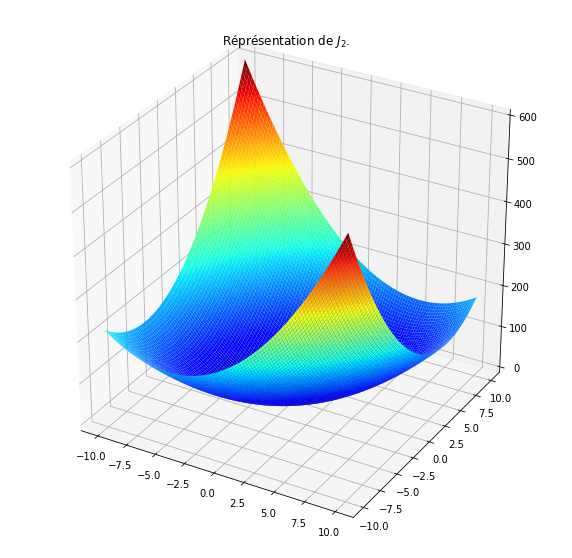

In [4]:
# Ré-implémentons J_2 sous sa forme canonique, ceci nous facilitera la représentation graphique.
def J_dim2(x, y):
  return 2 * x**2 - 2 * x * y + 2 * y**2 - x - y

# Notre pavé.
min = -10
max = 10

# Notre discrétisation.
x = np.linspace(min, max, 100)
y = np.linspace(min, max, 100)

X, Y = np.meshgrid(x, y)
Z = J_dim2(X, Y)

from mpl_toolkits.mplot3d import Axes3D # besoin pour graphique 3D.

# Visualisation graphique.
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = '3d')
ax.set_title("Réprésentation de $J_2$.");

ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'jet', 
                edgecolor = 'none');



---



Vérifions ensuite pour quelques valeurs de $n$, que $A_n$ est définie positive. Pour s'y faire, nous allons tout simplement regarder les valeurs propres de $A_n$. Si l'une d'entres elles est négatif ou nulle, on déduit qu'elle ne l'est pas. On utilisera la fonction linalg.eig() dans la bibliothèque numpy, qui nous renvoie les valeurs propres ainsi que les vecteurs propres.

In [5]:
N = [2, 3, 5, 7, 9, 10, 11, 20, 30, 50, 100, 255] # quelques valeurs de n.

for n in N:
  # booléan.
  is_pos = 1

  A = matrix_A(n)
  eigenvalues, eigenvectors = np.linalg.eig(A) 
  # np.linalg.eig() renvoie d'abord les valeurs propres puis les vecteurs propres.
  for i in eigenvalues:
    if(i <= 0):
      is_pos = 0
      break # Si l'une d'entres elles est <=0 alors on a plus besoin de continuer.

  if(is_pos):
    print("For n = " + str(n) + " A is definite positive.")
  else:
    print("For n = " + str(n) + " A is not definite positive.")

For n = 2 A is definite positive.
For n = 3 A is definite positive.
For n = 5 A is definite positive.
For n = 7 A is definite positive.
For n = 9 A is definite positive.
For n = 10 A is definite positive.
For n = 11 A is definite positive.
For n = 20 A is definite positive.
For n = 30 A is definite positive.
For n = 50 A is definite positive.
For n = 100 A is definite positive.
For n = 255 A is definite positive.


Dans le cas $n = 2$, nous obtenons que $A_2$ est définie positive. D'après le cour, on déduit que $J_2$ est strictement convexe (enfaite c'est le cas pour tout $n$) et donc par l'équivalence des conditions d'optimalité d'ordre 1, nous obtenons que le problème $inf_\mathbb{R^2}J_2(x)$ admet une unique solution $x^*$ qui est solution du système $A_2x^* = b_2$. $A_2$ étant inversible, nous obtenons $x^* = A_2^{-1}b_2$. Calculons la.

In [7]:
print("Solution for the problem P_2 : ", np.linalg.inv(matrix_A(2))@vector_b(2))

Solution for the problem P_2 :  [0.5 0.5]




---



Nous allons maintenant implémenter différents algorithme pour résoudre des problèmes d'optimisation sans contrainte. En particulier, on implémentera les méthodes de gradient.

In [6]:
# Il est important de choisir un pas ni trop grand ni trop petit pour l'algorithme
# du gradient à pas constant puisque si on prend un pas petit, notre convergence
# peut etre très très lente. Et si l'on prend un pas trop grand, on peut faire un saut
# très grand qui fait en sorte qu'on "passe" au dessus du minimun. 
 
# Gradient à pas constant : 

def grad_const(n, rho, x_0):
  it_max = 100000
  it = 0

  x_last = x_0
  d = - (matrix_A(n) @ x_last - vector_b(n)) 
  x_now = x_last + rho * d

  x = [x_0] # liste des itérations x^k.
  err = [] # liste d'erreurs.

  while ((np.linalg.norm(x_now - x_last) > 1e-12) and (it < it_max)):

    it += 1
    x.append(x_now)
    err.append(np.linalg.norm(x_now - x_last))

    x_last = x_now
    d = - (matrix_A(n) @ x_last - vector_b(n)) 
    x_now = x_last + rho * d
  
    x.append(x_now)
    err.append(np.linalg.norm(x_now - x_last))

  return x, err, it

In [8]:
# Un test de notre fonction.

N = 100
A_test = matrix_A(N)
b_test = vector_b(N)

eigenvalues = np.linalg.eig(A_test)[0] # On calcule les valeurs propres.
np.sort(eigenvalues) # On trie.

# Pas optimale.
pas = 2./(eigenvalues[0] + eigenvalues[-1])

# Un x_0 arbitraire.
x_0 = np.zeros(N)

x_appro, err, it = grad_const(N, pas, x_0)
x_exact = np.linalg.inv(A_test) @ b_test

print("Good solution ? : ", (np.linalg.norm(x_appro[-1] - x_exact) < 1e-8))

print("Iteration : ", it)

print("Good error ? :", (np.linalg.norm(x_appro[-1] - x_appro[-2]) < 1e-12) )

Good solution ? :  True
Iteration :  90388
Good error ? : True


In [9]:
# Gradient à direction conjugué : 

def grad_conjugue(n, x_0):
  it_max = n
  it = 0

  x_last = x_0
  r = matrix_A(n) @ x_last - vector_b(n) 
  d = r
  rho = - (np.dot(r, d) / np.dot(matrix_A(n)@d , d) )
  x_now = x_last + rho * d
  r = matrix_A(n) @ x_now - vector_b(n)

  x = [x_0] # liste des itérations x^k.
  err = [] # liste d'erreurs.

  while((np.linalg.norm(x_now - x_last) > 1e-12) and (it < it_max)):
    
    it += 1
    x.append(x_now)
    err.append(np.linalg.norm(r))

    if(np.linalg.norm(r) < 1e-12):
      break

    x_last = x_now
    alpha = - np.dot( matrix_A(n) @ r, d)/np.dot(matrix_A(n) @ d, d) 
    d = r + alpha * d

    rho = - np.dot(r, d)/np.dot(matrix_A(n) @ d, d)
    x_now = x_last + rho * d
    r = matrix_A(n) @ x_now - vector_b(n)

  return x, err, it # Cette fois-ci, on renvoie les itérations x^k, l'erreur e^k et le nombre d'itérations.

In [10]:
# Un test de notre fonction.

N = 1200
A_test = matrix_A(N)
b_test = vector_b(N)

# Un x_0 arbitraire.
x_0 = np.zeros(N)
x_appro, err, it = grad_conjugue(N, x_0)
x_exact = np.linalg.inv(A_test) @ b_test

print("Good solution ? : ", (np.linalg.norm(x_appro[-1] - x_exact) < 1e-6) )

print("Iteration : ", it) # Bien inférieur à N, ok pour le théorème.

print("Good error ? : ", (np.linalg.norm(A_test @ x_appro[-1] - b_test) < 1e-12) )

Good solution ? :  True
Iteration :  600
Good error ? :  True


Notre programme prend un certains temps, l'idée est d'exploiter le format creux des matrices. En particulier on peut utiliser le format CSR afin de diminuer largement les temps de calculs.

In [11]:
# Version creuse CSR.

#Multiplication d'une matrice par un vecteur, ici A par b.

#La fonction multiplication:
def matvect_multiply(A, b):
  y = np.zeros(np.size(b)) 
  for i in range(np.size(b)): 
    for j in range(A.indptr[i], A.indptr[i + 1]): 
      c = A.indices[j]
      y[i] = y[i] + A.data[j] * b[c]
  return y


# Gradient à pas variable : 

def grad_variable_CSR(n, x_0):
  it_max = 1000
  it = 0

  A = spsp.diags([[4.]*n, [-2]*(n-1), [-2] *(n-1)], [0,1,-1])
  A = spsp.csr_matrix(A) 

  x_last = x_0
  r = matvect_multiply(A, x_last) - vector_b(n) 
  d = r
  rho = - (np.dot(r, d) / np.dot(matvect_multiply(A, d) , d) )
  x_now = x_last + rho * d
  r = matvect_multiply(A, x_now) - vector_b(n)

  while((np.linalg.norm(x_now - x_last) > 1e-12) and (it < it_max)):

    if(np.linalg.norm(r) < 1e-12):
      break

    x_last = x_now
    alpha = - np.dot( matvect_multiply(A, r), d)/np.dot(matvect_multiply(A, d), d) 
    d = r + alpha * d

    rho = - np.dot(r, d)/np.dot(matvect_multiply(A, d), d)
    x_now = x_last + rho * d
    r = matvect_multiply(A, x_now) - vector_b(n)

    it += 1

  return x_now

In [12]:
deb = time.time()
N = 10000
x_0 = np.zeros(N)
x = grad_variable_CSR(N, x_0)
print(x);
fin = time.time()

print("time = ", fin - deb, "seconds.")

[2500.  4999.5 7498.5 ... 7498.5 4999.5 2500. ]
time =  131.7073564529419 seconds.


Pour un $N$ très grand, on obtient "que" $130$ secondes à l'aide du format CSR, tandis que si on utiliser l'agorithme classique, cela nous prendra très très longtemps.




In [13]:
# On implémente ensuite le gradient à pas optimale :

def grad_variable(n, x_0):
  it_max = 100000
  it = 0

  x_last = x_0
  d = matrix_A(n) @ x_last - vector_b(n) 
  rho = np.dot(d, d) / np.dot(matrix_A(n)@d , d) # formule du pas optimale.
  x_now = x_last - rho * d


  x = [x_0] # Liste des itérations x^k
  err = [] # Liste des erreurs.

  while ((np.linalg.norm(x_now - x_last) > 1e-12) and (it < it_max)): 
    
    it += 1
    err.append(np.linalg.norm(x_now - x_last))
    x.append(x_now)

    # L'algo du gradient :
    x_last = x_now
    d = matrix_A(n) @ x_last - vector_b(n) 
    rho = np.dot(d, d) / np.dot(matrix_A(n)@d , d)
    x_now = x_last - rho * d

  return x, err, it 

In [15]:
# Fixons un x_0 arbitraire.

n = 10
A_test = matrix_A(n)
b_test = vector_b(n)

x_0 = np.zeros(n)

# Appliquons la fonction ci-dessus et déterminons si c'est une bonne solution
x_appro, err, it = grad_variable(n, x_0)
x_exact = np.linalg.inv(A_test) @ b_test


print("Good solution ? : ", (np.linalg.norm(x_appro[-1] - x_exact) < 1e-6) )

print("Iteration : ", it) # Bien inférieur à N, ok pour le théorème.

print("Good error ? : ", (np.linalg.norm(A_test @ x_appro[-1] - b_test) < 1e-8) )

Good solution ? :  True
Iteration :  637
Good error ? :  True


  Pour $N = 2$.

Nombre d'itération : 41


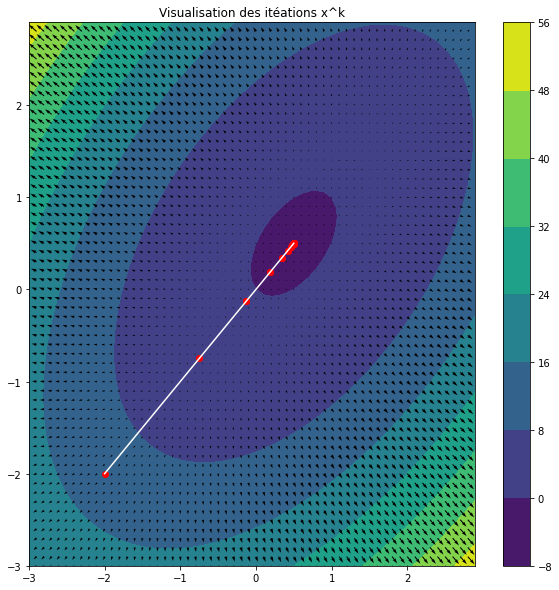

In [16]:
# Nous voulons afficher les lignes de niveaux de J ainsi que son champs de gradient.

fig, ax = plt.subplots(1, 1, figsize = (10,10))

# Domaine de discrétisation.
x1 = np.arange(-3.0, 3.0, 0.1)
x2 = np.arange(-3.0, 3.0, 0.1)

xx1, xx2 = np.meshgrid(x1,x2); 

Z = 2*xx1**2 + 2*xx2**2 -2*xx1*xx2-xx1-xx2;

# Lignes de niveaux.
h = plt.contourf(x1, x2, Z) 
fig.colorbar(h) 

# Pour le gradient.
U = 4*xx1-2*xx2-1 
V = 4*xx2-2*xx1-1 
Q = plt.quiver(x1, x2, U, V, units='width') 

# on trace ensuite les itérations x^k.

n = 2

A_test = matrix_A(n)
b_test = vector_b(n)

# Prenons un pas constant

vap = np.linalg.eigvals(A_test) 
np.sort(vap) # on trie les valeurs propres.
pas = 2./(vap[0] + vap[-1])  
# On prend le pas optimale.


x_0 = -2 * np.ones(n)

# On utilise la méthode du gradient à pas constant.
x_appro, err, it = grad_const(n, pas, x_0)
x_exact = np.linalg.inv(A_test) @ b_test

print( "Nombre d'itération :",it)

plt.scatter( np.array(x_appro)[:,0] , np.array(x_appro)[:,1], color = 'red')
plt.plot( np.array(x_appro)[:,0] , np.array(x_appro)[:,1], color = 'white', linestyle = 'solid') 

ax.set_title("Visualisation des itéations x^k");

Pour différents $N$.

In [17]:
n = [10, 20, 30, 50, 100] # Notre liste de N

constant=[]  #Liste qui, en chaque position n, stockera grad_const(n, pas, x_0) 
variable=[]  #Liste qui, en chaque position n, stockera grad_variable(n, x_0)


for i in range(len(n)):
  print("N = ", n[i])

  A_test = matrix_A(n[i])
  b_test = vector_b(n[i])
  x_0 = np.zeros(n[i])

  # Gradient à pas constant : 
  
  print("\n Gradient à pas constant \n")
  
  # On prend le pas optimal.
  vap = np.linalg.eigvals(A_test) 
  np.sort(vap) 
  pas = 2./(vap[0] + vap[-1])  

  x_appro, err, it = grad_const(n[i], pas, x_0)
  x_exact = np.linalg.inv(A_test) @ b_test

  constant.append(grad_const(n[i], pas, x_0))


  print("Good solution ? : ", (np.linalg.norm(x_appro[-1] - x_exact) < 1e-6) )

  print("Iteration : ", it) # Bien inférieur à N, ok pour le théorème.

  print("Good error ? : ", (np.linalg.norm(A_test @ x_appro[-1] - b_test) < 1e-8) )

  # Graddient à pas variable : 

  print("\n Gradient à pas variable \n")

  x_appro, err, it = grad_variable(n[i], x_0)
  x_exact = np.linalg.inv(A_test) @ b_test

  variable.append(grad_variable(n[i], x_0))


  print("Good solution ? : ", (np.linalg.norm(x_appro[-1] - x_exact) < 1e-6) )

  print("Iteration : ", it) # Bien inférieur à N, ok pour le théorème.

  print("Good error ? : ", (np.linalg.norm(A_test @ x_appro[-1] - b_test) < 1e-8) )

N =  10

 Gradient à pas constant 

Good solution ? :  True
Iteration :  838
Good error ? :  True

 Gradient à pas variable 

Good solution ? :  True
Iteration :  637
Good error ? :  True
N =  20

 Gradient à pas constant 

Good solution ? :  True
Iteration :  3044
Good error ? :  True

 Gradient à pas variable 

Good solution ? :  True
Iteration :  2429
Good error ? :  True
N =  30

 Gradient à pas constant 

Good solution ? :  True
Iteration :  6629
Good error ? :  True

 Gradient à pas variable 

Good solution ? :  True
Iteration :  5431
Good error ? :  True
N =  50

 Gradient à pas constant 

Good solution ? :  True
Iteration :  18340
Good error ? :  True

 Gradient à pas variable 

Good solution ? :  True
Iteration :  14884
Good error ? :  True
N =  100

 Gradient à pas constant 

Good solution ? :  True
Iteration :  90388
Good error ? :  True

 Gradient à pas variable 

Good solution ? :  True
Iteration :  59077
Good error ? :  True


On veut à présent comparer les deux méthodes de gradient avec ces différents $N$. En particulier on tracera l'erreur en fonction des itérations et on visualisera le nombre d'itération.

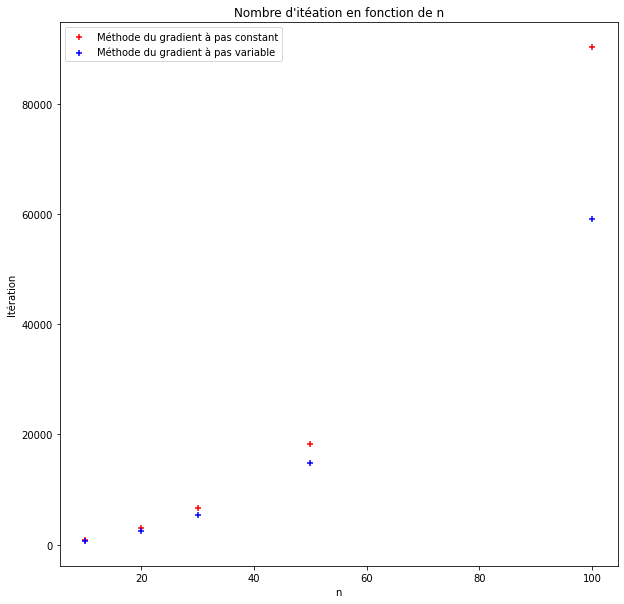

In [18]:
# On visualise le nombre d'itération en fonction de n.

# On stocke le nombre d'itéation de chaque méthode.
iteration_constant = []
iteration_variable = []

for i in range(len(n)):
  iteration_constant.append(constant[i][2])
  iteration_variable.append(variable[i][2])

fig, ax = plt.subplots(1, 1, figsize = (10,10))

plt.scatter(n, iteration_constant, color = 'red', marker='+', label = "Méthode du gradient à pas constant")
plt.scatter(n, iteration_variable, color = 'blue', marker='+', label = "Méthode du gradient à pas variable")

ax.set_title("Nombre d'itéation en fonction de n")
ax.set_xlabel("n")
ax.set_ylabel("Itération")
plt.legend();

On remarque clairement que la méthode du gradient à pas variable prend beaucoup moins de temps quand $N$ est très grand. Pour $N$ petit, on peut dire que la vitesse est plus ou moins équivalente.

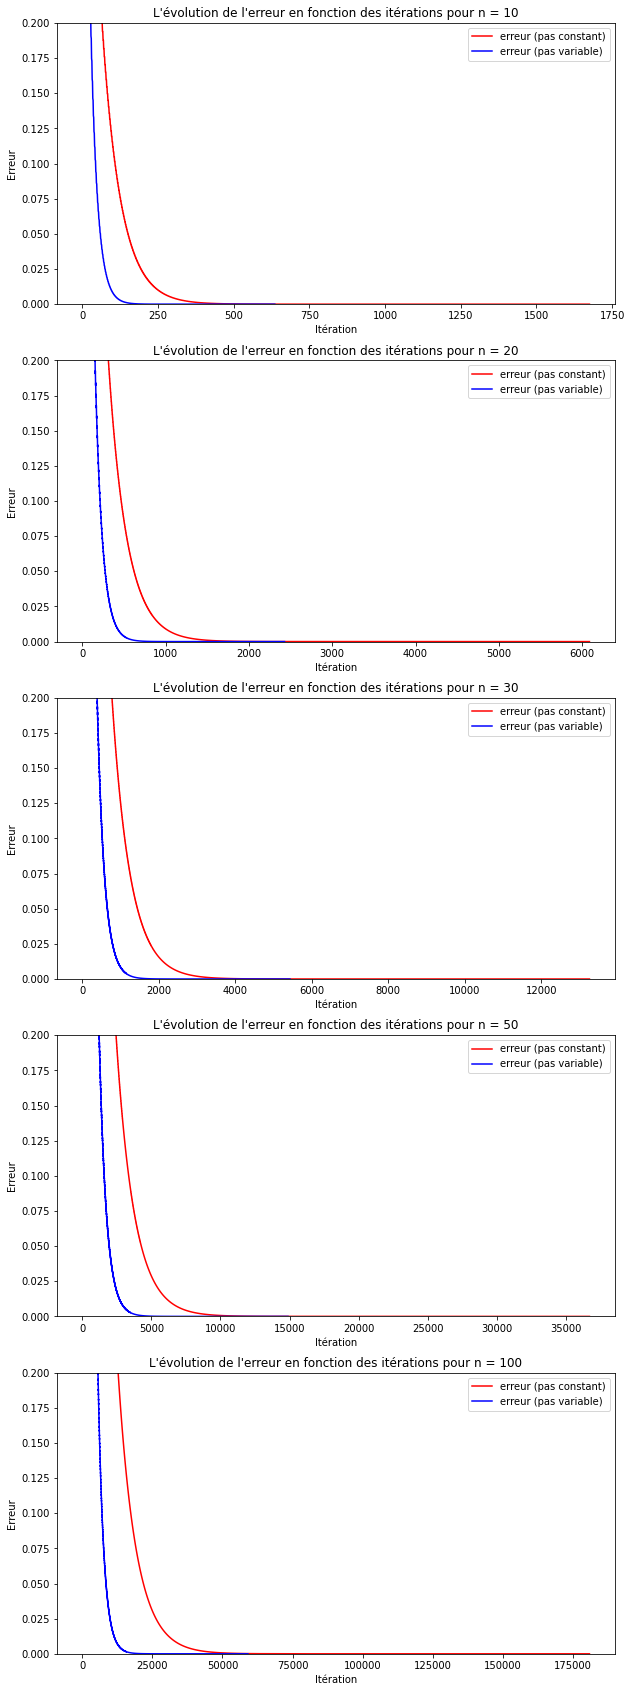

In [19]:
# On visualise ensuite l'erreur en fonction des itérations.

fig, ax = plt.subplots(len(n), 1, figsize = (10,30))

for i in range(len(n)):

  erreur_constant = constant[i][1]
  erreur_variable = variable[i][1]

  ax[i].plot(range(len(erreur_constant)), erreur_constant, color = 'red', label = "erreur (pas constant)")
  ax[i].plot(range(len(erreur_variable)), erreur_variable, color = 'blue', label = "erreur (pas variable)")

  ax[i].set_ylim(0, 0.2)
  ax[i].set_title("L'évolution de l'erreur en fonction des itérations pour n = " + str(n[i]))
  ax[i].set_xlabel("Itération")
  ax[i].set_ylabel("Erreur")

  ax[i].legend()

On remarque clairement que pour n'importe quel $n$, l'erreur diminue plus lentement pour la méthode à pas constant. On déduit que la méthode à pas variable est plus efficace quelque soit le $n$ qu'on prend.